<a href="https://colab.research.google.com/github/TsvetoslavVasev/Movie-Rec-System/blob/main/Rec_Systems_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект на тема:
## Експерименти с content based, различни collaborative filtering подходи и  хибриден подход върху MovieLens и TBDB-5000
### Николай Станчев ф.н. 8MI3400153, Цветослав Васев ф.н. 4MI3400015 

In [ ]:
import numpy as np
import pandas as pd
import os
import ast
import sklearn
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
%pip install surprise
from scipy.spatial.distance import cosine, correlation
from surprise import Reader, Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold ,GridSearchCV , RandomizedSearchCV
from keras.models import Sequential, Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import  Input, dot, concatenate, Embedding, Flatten, merge, Dropout, Dense, BatchNormalization, dot
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.constraints import non_neg
from IPython.display import SVG
from sklearn.metrics import mean_squared_error
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns', 50)
from google.colab import drive
drive.mount('/content/drive')
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import surprise
import sklearn
import datetime
import seaborn as sns
from sklearn.decomposition import NMF
%pip install annoy
from annoy import AnnoyIndex
import pickle
from surprise import NMF as surprise_nmf
from surprise.accuracy import rmse
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split as surprise_train_test_split
from keras.models import load_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# TBDB-5000 TF-IDF Content Based Recommandation 
Ще използваме tbdb-5000 дейтасета, съдържащ подробна информация за филми.
Препоръките ще ги генерираме, използвайка TF-IDF методологията от NLP.

In [ ]:
credits = pd.read_csv("drive/MyDrive/RecSys-Datasets/tmdb-5000/tmdb_5000_credits.csv")
movies = pd.read_csv("drive/MyDrive/RecSys-Datasets/tmdb-5000/tmdb_5000_movies.csv")

Нека разгледаме данните от дейтасета.

In [ ]:
display(credits.head(5))
display(movies.head(5))

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
credits.columns = ['id','tittle','cast','crew']
movies= movies.merge(credits,on='id')
plots = movies['overview']
tfidf = TfidfVectorizer(stop_words = 'english' , max_df = 4 , min_df= 1)
plots = plots.fillna('')
tfidf_matrix = tfidf.fit_transform(plots)


In [ ]:
cos_similar = linear_kernel(tfidf_matrix , tfidf_matrix)
cos_similar.shape

(4803, 4803)

In [ ]:
indices = pd.Series(movies.index , index = movies['title']).drop_duplicates()

In [ ]:
def get_similar_movies(title):
    idx = indices[title]
    similar = list(enumerate(cos_similar[idx]))
    similar = sorted(similar , key = lambda x: x[1] , reverse = True)
    similar = similar[:11]
    indic = []
    for i in similar:
        indic.append(i[0])
    return movies['title'].iloc[indic]


In [ ]:
get_similar_movies('Avatar')

0                                         Avatar
634                                   The Matrix
775                                    Supernova
1341                        The Inhabited Island
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
5                                   Spider-Man 3
6                                        Tangled
7                        Avengers: Age of Ultron
Name: title, dtype: object

In [ ]:
get_similar_movies('The Dark Knight Rises')

3                  The Dark Knight Rises
4466                              Vessel
136                            Bee Movie
428                       Batman Returns
1698                   The Rugrats Movie
672     Perfume: The Story of a Murderer
4566                        Diamond Ruff
979                  Free State of Jones
1433                   The Four Feathers
1124                            The Heat
2033      Deuce Bigalow: European Gigolo
Name: title, dtype: object

In [ ]:
get_similar_movies('American Psycho')

3257                             American Psycho
4142                             Supercapitalist
298                      The Wolf of Wall Street
1109                               Heaven's Gate
999                    What Planet Are You From?
4394                          The Last Big Thing
0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
Name: title, dtype: object

# MovieLens Dataset EDA

За проекта ще обърнем особено внимание на MovieLens дейтасета. Нека изборим кои са файловете включени в него.

In [ ]:
print(os.listdir('drive/MyDrive/RecSys-Datasets/ml-100k'))
#print(os.listdir('drive/MyDrive/ml-latest'))

['mku.sh', 'allbut.pl', 'u.user', 'u.genre', 'u.info', 'u.occupation', 'u.data', 'u.item', 'u1.test', 'u1.base', 'u2.test', 'u2.base', 'u3.test', 'u3.base', 'u4.test', 'u4.base', 'u5.test', 'u5.base', 'ua.test', 'ua.base', 'ub.base', 'ub.test', 'README']


Дейтасета съдържа и README.md файл, който представлява подробно описание на съдържанието на различните файлове.

In [ ]:
readme = open('drive/MyDrive/ml-latest/README.txt','r') 
print(readme.read())

Summary

This dataset (ml-latest) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLe

Нека разгледама данните за рейтинги на юзъри.

In [ ]:
rating_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/ratings.csv')

In [ ]:
movies_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/movies.csv')

In [ ]:
rating_dt.shape

(27753444, 4)

In [ ]:
rating_dt.head(10)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
5,1,1590,2.5,1256677236
6,1,1591,1.5,1256677475
7,1,2134,4.5,1256677464
8,1,2478,4.0,1256677239
9,1,2840,3.0,1256677500


Ще проверим за записи записи с нулеви стойности.

In [ ]:
rating_dt.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
rating_dt['rating'].describe()

count    2.775344e+07
mean     3.530445e+00
std      1.066353e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Ставя ясно, че средната оценка на филми е около 3.5

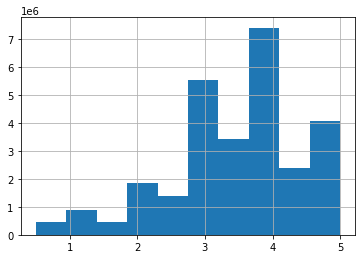

In [ ]:
rating_dt['rating'].hist(bins=10)

От графиката забелязваме, че потребителите поставят оценки по-високи или около 3, отколкото много ниски оценки.

Нека видим кога е оставена първата и последна оценка на филм.

In [ ]:
from datetime import datetime
print(datetime.utcfromtimestamp(rating_dt['timestamp'].min()).strftime('%Y-%m-%d %H:%M:%S'))

1995-01-09 11:46:44


In [ ]:
from datetime import datetime
print(datetime.utcfromtimestamp(rating_dt['timestamp'].max()).strftime('%Y-%m-%d %H:%M:%S'))

2018-09-26 06:59:09


Нека видим и за кои филми са тези оценки.

In [ ]:
oldest_rated_movie = rating_dt.loc[rating_dt['timestamp'] == rating_dt['timestamp'].min(), 'movieId'].item()
movies_dt.loc[movies_dt['movieId'] == oldest_rated_movie]

,movieId,title,genres
1153,1176,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance


In [ ]:
latest_rated_movie = rating_dt.loc[rating_dt['timestamp'] == rating_dt['timestamp'].max(), 'movieId'].item()
movies_dt.loc[movies_dt['movieId'] == latest_rated_movie]

,movieId,title,genres
46444,167780,Superman/Shazam!: The Return of Black Adam (2010),Action|Animation


Нека разгледаме данните за филми.

In [ ]:
movies_dt.shape

(58098, 3)

In [ ]:
movies_dt.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Отново проверяваме за записи с нулеви стойности.

In [ ]:
movies_dt.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

В дейтасета се съдържат и файлове с данни за links, tags, genome-tags, genome-scores.

In [ ]:
links_dt = pd.read_csv('drive/MyDrive/ml-latest/links.csv')

In [ ]:
links_dt.head(10)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
5,6,113277,949.0
6,7,114319,11860.0
7,8,112302,45325.0
8,9,114576,9091.0
9,10,113189,710.0


In [ ]:
tags_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/tags.csv')

In [ ]:
tags_dt.head(10)

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
5,14,318,justice,1442615192
6,14,480,Dinosaurs,1443148563
7,14,593,psychothriller,1444014286
8,14,1682,philosophy,1442615158
9,14,1682,surveillance,1442615167


In [ ]:
genome_tags_dt = pd.read_csv('drive/MyDrive/ml-latest/genome-tags.csv')

In [ ]:
genome_tags_dt.head(10)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


In [ ]:
genome_scores_dt = pd.read_csv('drive/MyDrive/ml-latest/genome-scores.csv')

In [ ]:
genome_scores_dt.head(10)

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000
5,1,6,0.19525
6,1,7,0.07600
7,1,8,0.25200
8,1,9,0.22750
9,1,10,0.02400


#Collaborative - item-based

Зареждаме дейтасета и ще работим с негова частична представителна извадка с големина 10% от оригиналния.

In [ ]:
rating_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/ratings.csv')

In [ ]:
user_ids = rating_dt["userId"].unique().tolist() 
num_all_user = len(user_ids)

# randomly select 10% users from rating dataset 
np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.1), replace=False)
sample_df = rating_dt.loc[rating_dt['userId'].isin(rand_userid)]
sample_df = sample_df[['userId','movieId','rating']]

In [ ]:
len(rand_userid)

28322

In [ ]:
sample_df.shape

(2720982, 3)

Ще използваме KNNwithMeans алгоритъма от библиотеката Suprise, който е разширание на KNN като в допълнение използва средното от рейтингите на всеки потребител.

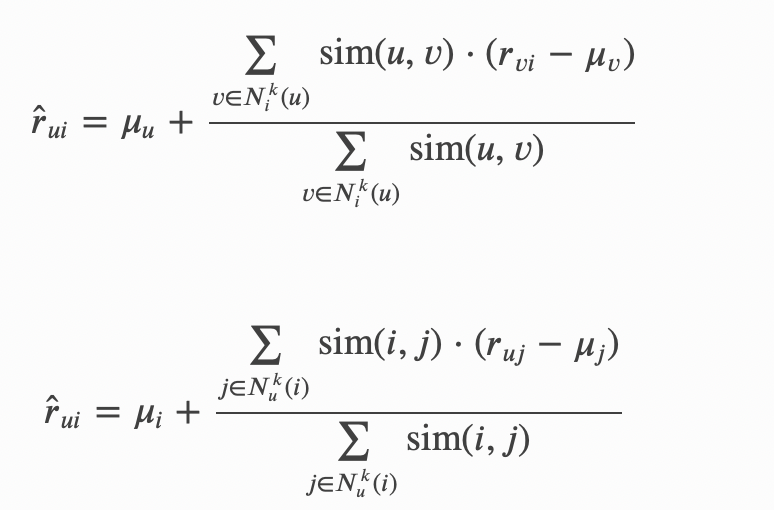

In [ ]:
# read the pandas dataframe as surprise dataframe
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(sample_df,reader)

# set up the kNN model
my_k = 15
my_min_k = 5
my_sim_option = {'name':'pearson',
                 'user_based':False}
algo = surprise.KNNWithMeans(k = my_k, min_k = my_min_k, sim_option = my_sim_option)

# split and train the data
trainset, testset = surprise.model_selection.train_test_split(data, test_size=0.25)
predictions = algo.fit(trainset).test(testset)
surprise.accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9098


0.9097534384233561

Като метрика за оценка ще използваме nDCG (normalised Discounted Cumulative Gain), която наказва по-късно препоръчани по-релевантни филми. nDCG = DCG/iDCG

In [ ]:
np.random.seed(123)
userid_random = np.random.choice(user_ids, 100, replace=False)
rel_list = []
predictions_df = pd.DataFrame(predictions)
for user in userid_random:
    recommended = []
    rate = []
    user_predictions = predictions_df.loc[user == predictions_df['uid']]
    top_20_user_predictions = user_predictions.sort_values(by=['est'], ascending=False).head(20)

    rel = []    
    for index, row in top_20_user_predictions.iterrows():
        if row['r_ui'] >= 4:
            rel.append(2)
        elif row['r_ui'] >= 2 and row['r_ui'] < 4:
            rel.append(1)
        else:
            rel.append(0)
    rel_list.append(rel)
dcg_sum = 0

ndcg_sum = 0
for r in rel_list:
    dcg = 0
    idcg = 0
    for i, value in enumerate(r):
        dcg += value/np.log(i+2)
    r.sort(reverse=True)
    for i, value in enumerate(r): 
        idcg += value/np.log(i+2)
    ndcg = 0
    if idcg != 0:
      ndcg = dcg/idcg
    ndcg_sum += ndcg

print(ndcg_sum/len(rel_list))

0.927518699213907


#Neural-Collaborative Filtering

Ще направим експеримент с NCF (Neural-Collaborative Filtering) върху дейтасетa. Кодът ни представлява имплементация на модела, предложен от статията: [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031.pdf). 

Моделът е базиран на дълбока невронна мрежа, като комбинира два подхода: 
- стандартна факторизация на матрици, чрез невронна мрежа (не се използва активираща функция).
- MLP (Multi Layer Perceptron), състоящ се от няколко невронни слоя, при който вече има активираща функция ReLu, за да се опишат нелинейни зависимости.
Резултатът от двете се конкатенира и отново преминава през ReLu функция и дава финалните препоръки.

При MLP използваме Dropout и Batch Normalization, за постигане на по-добра генерализация и предотвратяване на overfiting. За тази цел ще използваме Keras, по-конкретно неговия Functional API.



In [ ]:
# date parse format
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

In [ ]:
rating_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/ratings.csv', 
                       )
movie_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/movies.csv')
tag_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/tags.csv', parse_dates=['timestamp'])

In [ ]:
# all unique user ids
user_ids = rating_dt["userId"].unique().tolist() 
num_all_user = len(user_ids)

# randomly select 10% users from rating dataset 
np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.1), replace=False)
sample_df = rating_dt.loc[rating_dt['userId'].isin(rand_userid)]

# userid, movieid encoding by indices
user_ids = sample_df['userId'].unique()
num_users = len(user_ids)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
sample_df['user_encoded'] = sample_df['userId'].map(user2user_encoded)

movie_ids = sample_df['movieId'].unique()
num_movies = len(movie_ids)
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
sample_df['movie_encoded'] = sample_df['movieId'].map(movie2movie_encoded)

# train-test split
train, test = sklearn.model_selection.train_test_split(sample_df, test_size = 0.2, random_state=123)

num_train_user = len(np.unique(train['user_encoded']))
num_train_movie = len(np.unique(train['movie_encoded']))

print(f'total movie: {num_movies}', 
      f'\nmovie in train: {num_train_movie}', 
      f'\nmovie not in train: {num_movies - num_train_movie} ({1 - num_train_movie / num_movies :.2f})', 
      f'\n\ntotal user: {num_users}', 
      f'\nuser in train: {num_train_user}', 
      f'\nuser not in train: {num_users - num_train_user} ({1 - num_train_user / num_users :.2f})'
     )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


total movie: 27374 
movie in train: 25680 
movie not in train: 1694 (0.06) 

total user: 28322 
user in train: 28177 
user not in train: 145 (0.01)


Ембединг и модел

In [ ]:
# input: an integer as embedding layer size, a float as drop out probability
# output: a keras NCF model with pre-constructed layers
def NCF_model(embed_size = 10, drop_out_prob = 0.2): 
    # define spaceholder of embedding inputs
    movie_input = Input(shape=[1],name='movie-input')
    user_input = Input(shape=[1], name='user-input')

    # MLP embeddings for both user and movie
    movie_embedding_mlp = Embedding(num_movies, embed_size, 
                                    name='movie-embedding-mlp')(movie_input)
    movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)
    movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

    user_embedding_mlp = Embedding(num_users, embed_size, 
                                   name='user-embedding-mlp')(user_input)
    user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

    # MF embeddings for both user and movie
    movie_embedding_mf = Embedding(num_movies, embed_size, 
                                   name='movie-embedding-mf')(movie_input)
    movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

    user_embedding_mf = Embedding(num_users, embed_size, 
                                  name='user-embedding-mf')(user_input)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

    # MLP layers
    concat = concatenate([movie_vec_mlp, user_vec_mlp], axis=-1, name='concat')
    concat_dropout = Dropout(drop_out_prob)(concat)

    fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
    fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
    fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

    fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
    fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
    fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

    # Prediction from both layers
    pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
    pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, normalize=False)

    combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=-1, name='pred_mf')

    # Final prediction
    result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

    model = Model([user_input, movie_input], result)
    model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


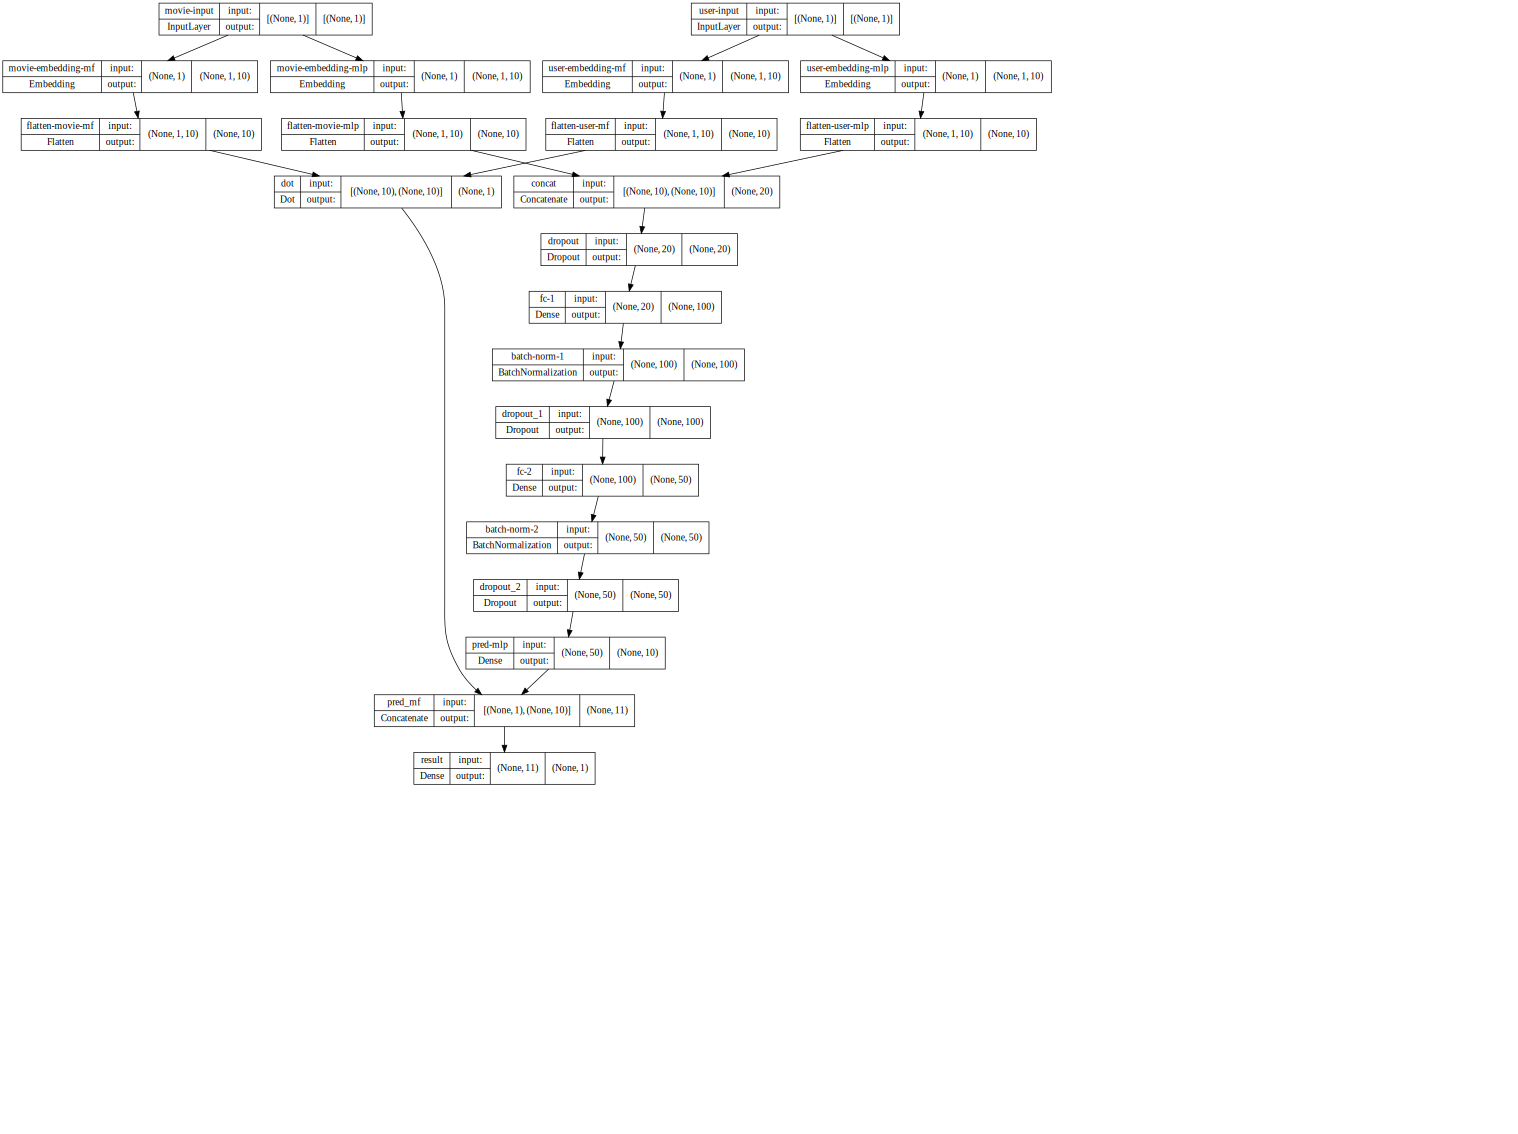

In [ ]:
model = NCF_model()

# set plotmodel path
os.environ["PATH"] += os.pathsep + "/usr/bin/dot"

# plot NCF model architecture
SVG(model_to_dot(model, dpi=50, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding-mlp (Embedding  (None, 1, 10)       273740      ['movie-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       283220      ['user-input[0][0]']         

In [ ]:
# train NCF model on training data, embedding size 15, dropout rate as default
model = NCF_model(embed_size=15)
history = model.fit([train['user_encoded'], train['movie_encoded']], train['rating'], epochs=5)

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

Зареждаме предварително трениран модел.

In [ ]:
# uncomment to save model as 'dl_model.h5'
# model.save('drive/MyDrive/Rec-Sys-models/dl_model.h5')

# # uncomment to load model
# from keras.models import load_model
model = keras.models.load_model('drive/MyDrive/Rec-Sys-models/dl_model.h5')

In [ ]:
# rmse on testing set 
y_hat = np.round(model.predict([test['user_encoded'], test['movie_encoded']]), decimals=2)
y_true = test['rating']
print(f'testing rms: {mean_squared_error(y_true, y_hat)}')

testing rms: 0.7349068929531704


In [ ]:
# prediction sample
d = {'prediction': y_hat.tolist(), 'true_value': y_true.values.tolist()}
test_pred = pd.DataFrame(d)
test_pred.head(5)

,prediction,true_value
0,[2.859999895095825],3.0
1,[3.4000000953674316],4.0
2,[3.549999952316284],3.5
3,[3.9700000286102295],4.0
4,[4.110000133514404],3.0


Ще разгледаме как се представя модела върху активни/неактивни потребители.

Забелязваме, от разпределението на потребителски рейтинги, че половината от потребителите са оценили 50 или по-малко филма. Препоръчващата система може да има по-лощо представяне, когато препоръчва на по-неактивен потребител.

Заради това е важно да се оцени представянето на NCF модела върху активни и неактивни потребители. Ще разделим потребителите на шест групи, тези които са оценили по-малко то 10, тези между 10 и 20, между 20 и 50, между 50 и 80, между 80 и 150, и тези над 150.

In [ ]:
# count number of ratings for all users
user_counts = sample_df.groupby('userId').size()

[(0.0, 6000.0),
 (0.0, 400.0),
 Text(0.5, 0, 'Number of Ratings'),
 Text(0.5, 1.0, 'Distribution of User Ratings')]

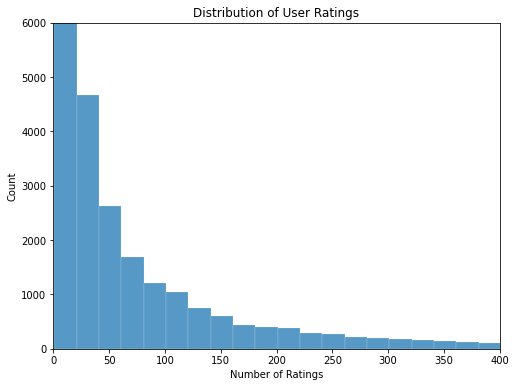

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')

sns.histplot(user_counts, binwidth=20, ax=ax)
ax.set(ylim=[0,6000], xlim=[0,400], title='Distribution of User Ratings', xlabel='Number of Ratings')

In [ ]:
# classify user base on counts of rating
active_levels = ['<10', '10-20', '20-50', '50-80', '80-150', '>150']

user_counts_levels = dict.fromkeys(active_levels, None)
user_counts_levels['<10'] = user_counts[user_counts < 10]
user_counts_levels['10-20'] = user_counts[(user_counts >= 10) & (user_counts < 20)]
user_counts_levels['20-50'] = user_counts[(user_counts >= 20) & (user_counts < 50)]
user_counts_levels['50-80'] = user_counts[(user_counts >= 50) & (user_counts < 80)]
user_counts_levels['80-150'] = user_counts[(user_counts >= 80) & (user_counts < 150)]
user_counts_levels['>150'] = user_counts[user_counts >= 150]

In [ ]:
# calculate rmse for all groups of user
user_level_rmse = []
for key in active_levels:
    indices = user_counts_levels[key].index.tolist()
    pred_df = sample_df[sample_df['userId'].isin(indices)]
    y_true = pred_df['rating']
    y_pred = model.predict([pred_df['user_encoded'], pred_df['movie_encoded']])
    user_level_rmse.append(mean_squared_error(y_true, y_pred))

Интересно е, че препоръките на нашия модел имат по-голяма грешка върху потребители, които са оценили до 20 филма. Понеже има стотици хиляди записи за двете групи щзъри, които влизат в тази категория, наблюдениято е достоверно.

[Text(0, 0.5, 'rmse'),
 [Text(0, 0, '<10'),
  Text(0, 0, '10-20'),
  Text(0, 0, '20-50'),
  Text(0, 0, '50-80'),
  Text(0, 0, '80-150'),
  Text(0, 0, '>150')],
 Text(0.5, 0, 'Number of ratings')]

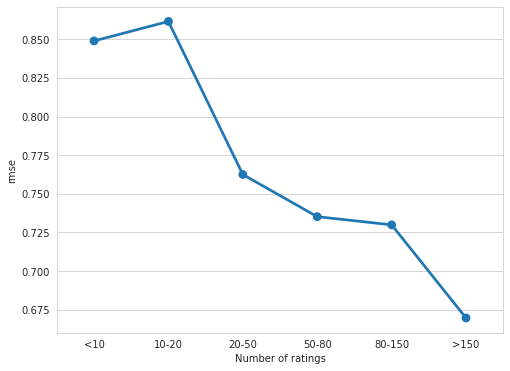

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')

sns.pointplot(y=user_level_rmse, x=np.arange(6))
ax.set(xticklabels=active_levels, xlabel='Number of ratings', ylabel='rmse')

Кросвалидация

По-горе забелязхме, че броят епохи не е основният ограничаващ проблем върху представянето на модела. Може да оптимизират learning rate-а и размерността на embedding слоя.
Често се използва 0.01 като learning rate при обучение, ще се фокусираме да намерим оптимален размер на embedding слоя. Ще пробваме 5 различни размерности. Излиза, че модели с размер на embedding слоя от 15 и 30 се представят по-добре в сравнение с останалите стойности при 3-fold кросвалидация. За предварително обучения модел сме използвали размер 15 за embedding слоя.

In [ ]:
from sklearn.model_selection import KFold

# sample 100k from training set as validation set 
valid_df_size = 100000
valid_df = train.sample(n = int(valid_df_size), replace=False, random_state=123)

embedding_layers = [5, 10, 15, 20, 25, 30]

In [ ]:
# input: validation data set, list of embedding layer size, drop-out probability, number of epochs, number of fold
# output: list of cv-rmse for each hyperparameter value
def NCF_cross_validation(cv_df, eb_layers, drop_prob = 0.2, epoch=3, n_split=3):
    cv_result = []

    for el in eb_layers:      
        temp_loss = []
        itr_idx = 0
        
        for train_idx, test_idx in KFold(n_split).split(cv_df):          
            cv_train_x = cv_df.iloc[train_idx][['user_encoded', 'movie_encoded']]
            cv_test_x = cv_df.iloc[test_idx][['user_encoded', 'movie_encoded']]
            cv_train_y = cv_df.iloc[train_idx]['rating']
            cv_test_y = cv_df.iloc[test_idx]['rating']

            model_cv = NCF_model()
            model_cv.fit([cv_train_x['user_encoded'], cv_train_x['movie_encoded']], cv_train_y, epochs=epoch)

            curr_loss = model_cv.evaluate([cv_df['user_encoded'], cv_df['movie_encoded']], cv_df['rating'])
            temp_loss.append(curr_loss)         
            itr_idx += 1
            
        cv_result.append(sum(temp_loss) / n_split)
            
    return cv_result

In [ ]:
cv_result = NCF_cross_validation(valid_df, embedding_layers)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2084/2084 [==============================] - 23s 10ms/step - loss: 1.2185
Epoch 2/3
2084/2084 [==============================] - 24s 11ms/step - loss: 0.8959
Epoch 3/3
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5637
Epoch 1/3
2084/2084 [==============================] - 34s 15ms/step - loss: 1.2501
Epoch 2/3
2084/2084 [==============================] - 25s 12ms/step - loss: 0.8680
Epoch 3/3
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5079
Epoch 1/3
2084/2084 [==============================] - 32s 15ms/step - loss: 1.2234
Epoch 2/3
2084/2084 [==============================] - 34s 16ms/step - loss: 0.9125
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.6215
Epoch 1/3
2084/2084 [==============================] - 34s 16ms/step - loss: 1.2111
Epoch 2/3
2084/2084 [==============================] - 29s 14ms/step - loss: 0.9069
Epoch 3/3
3125/3125 [==============================] - 5s 2ms/step - loss: 0.5242
Epoch 1/3


[Text(0, 0.5, 'CV rmse'),
 Text(0.5, 0, 'Embedding Dim'),
 Text(0.5, 1.0, '3-Fold CV')]

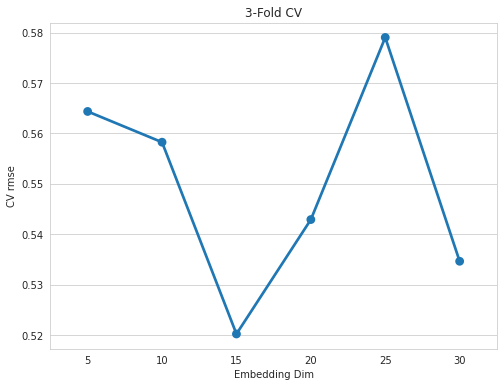

In [ ]:
cv_result_df = pd.DataFrame({'cv_rmse': cv_result}, index = embedding_layers)

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df.index, y=cv_result_df.cv_rmse, ax=ax)
ax.set(xlabel='Embedding Dim', ylabel='CV rmse', title='3-Fold CV')

Топ 20 препоръчани филма

In [ ]:
# input: a recommendation model (keras model), user id, number of recommendation
# output: a dataframe of top-k recommendations along with movie information
def NCF_recommendation(rec_model, client_id, top_k = 20):
    client_encoded = user2user_encoded[client_id]
    movie_watched = sample_df[sample_df['userId'] == client_id]['movieId'].values
    
    movie_poll_encoded = []
    for item in movie_ids:
        if not np.isin(item, movie_watched):
            movie_poll_encoded.append(movie2movie_encoded[item])
            
    d = {'user_encoded': [client_encoded] * len(movie_poll_encoded), 'movie_encoded' : movie_poll_encoded}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['user_encoded'], client_df['movie_encoded']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [movie_encoded2movie.get(movie_poll_encoded[x]) for x in top_ratings_idx]
    
    top_movie_rec = pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings}).set_index('movieId')
    top_movie_rec = top_movie_rec.join(movie_dt.set_index('movieId'))

    return top_movie_rec

In [ ]:
client_id = int(np.random.choice(user_ids, 1))
print(f'recommendation for client: {client_id}')
NCF_recommendation(model, client_id, top_k=20)

recommendation for client: 269221


,prediction,title,genres
movieId,,,
65188,4.400249,Dear Zachary: A Letter to a Son About His Fath...,Documentary
174053,4.390895,Black Mirror: White Christmas (2014),Drama|Horror|Mystery|Sci-Fi|Thriller
171011,4.381157,Planet Earth II (2016),Documentary
159817,4.375107,Planet Earth (2006),Documentary
170705,4.368484,Band of Brothers (2001),Action|Drama|War
858,4.360006,"Godfather, The (1972)",Crime|Drama
5147,4.346227,Wild Strawberries (Smultronstället) (1957),Drama
670,4.335399,"World of Apu, The (Apur Sansar) (1959)",Drama
2324,4.321900,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War


In [ ]:
# input: same as NCF_recommendation
# output: top-k recommendations, recommendations include movies that have been watched
def NCF_recommendation_eval_dcg(rec_model, client_id, top_k = 20):
    client_encoded = user2user_encoded[client_id]
    # movie_watched = sample_df[sample_df['userId'] == client_id]['movieId'].values
    
    movie_poll_encoded = []
    for item in test.loc[test['userId'] == client_id, 'movieId']:
        #if not np.isin(item, movie_watched):
        movie_poll_encoded.append(movie2movie_encoded[item])
            
    d = {'user_encoded': [client_encoded] * len(movie_poll_encoded), 'movie_encoded' : movie_poll_encoded}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['user_encoded'], client_df['movie_encoded']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [movie_encoded2movie.get(movie_poll_encoded[x]) for x in top_ratings_idx]
    
    top_movie_rec = pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings}).set_index('movieId')
    top_movie_rec = top_movie_rec.join(movie_dt.set_index('movieId'))

    return top_movie_rec

In [ ]:
#client_id = int(np.random.choice(user_ids, 1))
client_id = 45817
print(f'recommendation for client: {client_id}')
NCF_recommendation_eval_dcg(model, client_id, top_k=20)

recommendation for client: 45817


,prediction,title,genres
movieId,,,
50,4.053559,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
1222,3.884712,Full Metal Jacket (1987),Drama|War
1214,3.822100,Alien (1979),Horror|Sci-Fi
593,3.756588,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
541,3.607438,Blade Runner (1982),Action|Sci-Fi|Thriller
1208,3.597288,Apocalypse Now (1979),Action|Drama|War
2329,3.584235,American History X (1998),Crime|Drama
47,3.582180,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
1258,3.553072,"Shining, The (1980)",Horror


nDCG оценка

In [ ]:
user_ids = test["userId"].unique().tolist()
np.random.seed(123)
userid_random = np.random.choice(user_ids, 100, replace=False)
rel_list = []

for user in userid_random:
    user_predictions = NCF_recommendation_eval_dcg(model, user, top_k=20)
    recommended = []
    rate = []
    rel = []    
    for movieId, row in user_predictions.iterrows():
        real_rating = test.loc[(test['userId'] == user) & (test['movieId'] == movieId), 'rating'].item()
        if real_rating >= 4:
            rel.append(2)
        elif real_rating >= 2 and real_rating < 4:
            rel.append(1)
        else:
            rel.append(0)
    rel_list.append(rel)

dcg_sum = 0
ndcg_sum = 0

for r in rel_list:
    dcg = 0
    idcg = 0
    for i, value in enumerate(r):
        dcg += value/np.log(i+2)
    r.sort(reverse=True)
    for i, value in enumerate(r): 
        idcg += value/np.log(i+2)
    ndcg = 0
    if idcg != 0:
      ndcg = dcg/idcg
    ndcg_sum += ndcg

print(ndcg_sum/len(rel_list))

0.9636964777135002


#MF_ANN_Model

Ще направим експеримент с Matrix Factorization, по-конкретно NMF. Това е процес, при който матрица V се факторизира с други две матрици, като трите матрици имат само ненулеви стойности, което прави разглеждането по-лесно и е по-подходящо решение за някои проблеми. Ще използваме имплементация на NMF от Surprise. Освен Matrix Factorization ще използваме и Aproximate Nearest Neighbours (ANN). За ралика от KNN, при който се разлегждат всички точкки, при ANN търсенето на съседи започва само от начална извадка от кандидат съседи. За ANN върху вектори ще използваме библиотеката Annoy.

In [ ]:
# load data
rating_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/ratings.csv')
movie_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/movies.csv')
print(rating_dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB
None


In [ ]:
# randomly select 10% users from rating dataset 
user_ids = rating_dt["userId"].unique().tolist() 
num_all_user = len(user_ids)

np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.1), replace=False)
sample_df = rating_dt.loc[rating_dt['userId'].isin(rand_userid)]

sample_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


Метод за трансформиране на дейтафреймовете в csr (Compressed Sparse Row) матрица, с която забързваме процеса по умножение на матрици.

In [ ]:
def movie_use_matrix_pivot(df_):
    mu_matrix = df_.pivot(index = 'userId', 
                          columns = 'movieId', 
                          values = 'rating').fillna(0)
    # compress original matrix
    mu_matrix_cp = csr_matrix(mu_matrix.values)
    return mu_matrix, mu_matrix_cp
    
# get rating matrix
rating_matrix, rating_matrix_cp = movie_use_matrix_pivot(sample_df)

Дефинираме метод, използвамщ NMF от Surprise за намираме латентните фактори за даден елемент.

In [ ]:
# input: number of latent factors - dimension; compressed rating matrix - data
# output: return the item latent factors
def get_item_latent_factor(dimension, matrix_cp):
    nmf_model = NMF(n_components=dimension)
    # Matrix factorization               
    nmf_model.fit(matrix_cp)
    item_vectors = nmf_model.components_.T
    return item_vectors

Метод, връщащ RMSE за подадени данни и брой латентни фактори.

In [ ]:
# input: data and number of factors
# output: rmse
def get_nmf_rmse(sample_data, num_factors):
    reader = Reader(rating_scale=(0, 5))
    data = Dataset.load_from_df(sample_data[['userId', 'movieId', 'rating']], reader)
    trainset, testset = surprise_train_test_split(data, test_size=0.2)
    algo = surprise_nmf(n_factors = num_factors)
    predictions = algo.fit(trainset).test(testset)
    acc = accuracy.rmse(predictions)
    return acc

Кросвалидация

In [ ]:
# tuning number of factors with cv
mean_scores = []
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(sample_df[['userId', 'movieId', 'rating']], reader)
num = [10, 14, 18, 22, 26]
for n in [10, 14, 18, 22, 26]:
    nmf_model = surprise_nmf(n_factors = n)
    score = cross_validate(nmf_model, data, measures=['RMSE'], cv=3, verbose=False)['test_rmse']
    mean_scores.append(score.mean())

In [ ]:
mean_scores

[0.9097010220801742,
 0.891210309517643,
 0.8924474364833243,
 0.9019366698875109,
 0.9134545230068687]

Нека видим как се променя грешката по-различните брой фактори от кросвалидацията.

In [ ]:
get_nmf_rmse(sample_df, 14)
get_nmf_rmse(sample_df, 20)
get_nmf_rmse(sample_df, 30)
get_nmf_rmse(sample_df, 10)
get_nmf_rmse(sample_df, 15)

RMSE: 0.8895
RMSE: 0.8917
RMSE: 0.9227
RMSE: 0.9056
RMSE: 0.8858


0.8858431502009675

[Text(0, 0.5, 'CV rmse'),
 Text(0.5, 0, 'Number of Latent Factors in NMF'),
 Text(0.5, 1.0, '3-Fold CV')]

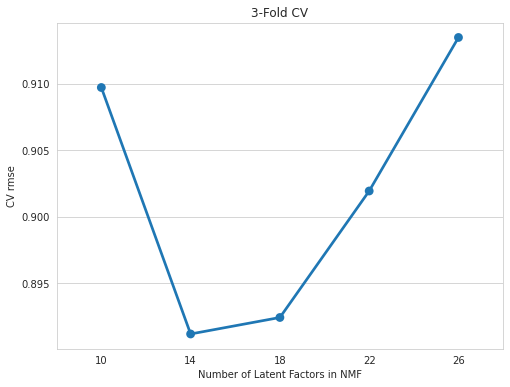

In [ ]:
cv_result_df = pd.DataFrame({'cv_rmse': mean_scores, 'n_factors': num})

fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x=cv_result_df.n_factors, y=cv_result_df.cv_rmse, ax=ax)
ax.set(xlabel='Number of Latent Factors in NMF', ylabel='CV rmse', title='3-Fold CV')

Този блок запазва модела.

In [ ]:
## save the best NMF model (nu_components 14)
# nmf_model = NMF(n_components=14)     
# nmf_model.fit(rating_matrix_cp)  
# filename = 'nmf_model.sav'
# pickle.dump(nmf_model, open(filename, 'wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Зареждаме запазеният трениран модел.

In [ ]:
filename = 'drive/MyDrive/Rec-Sys-models/nmf_model/nmf_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
item_vector = loaded_model.components_.T

In [ ]:
item_vector

array([[2.77368182e-01, 3.43580799e-01, 6.47565824e-01, ...,
        1.03861537e+00, 0.00000000e+00, 3.73868206e-01],
       [2.45976468e-01, 3.33278618e-02, 1.63579583e+00, ...,
        0.00000000e+00, 3.72583911e-01, 4.02881513e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.26620503e-01, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.46629648e-03, 6.41379922e-04],
       [0.00000000e+00, 1.78406712e-03, 0.00000000e+00, ...,
        8.92895634e-04, 0.00000000e+00, 1.27128407e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.17822244e-04, 0.00000000e+00, 3.57921452e-04]])

In [ ]:
# pickle.dump(item_vector, open('item_list', 'wb'))

Метод за за постряване на файл, съхраняващ данни, които използваме при ANN.

In [ ]:
# Implement Approximate Nearest Neighborhood to find similar items, save it in 'rating.ann' 
# input: target movie, rating matrix, item_vectors, metric (can be "angular", "euclidean", "manhattan", "hamming")
# number of trees(More trees gives higher precision when querying)
# output: save it in 'rating.ann'
def ann(matrix, item_vectors, metric, num_trees):
    # construct a dictionary where movied id contains its vector representation
    movieids = matrix.columns.tolist()
    rating_dictionary = {movieids[i]: item_vectors[i] for i in range(len(movieids))} 
    f = len(item_vectors[1])
    t = AnnoyIndex(f, metric)
    for key in rating_dictionary:
        t.add_item(key, rating_dictionary.get(key))
    t.build(num_trees)
    filepath = 'rating' + str(num_trees) + '.ann'
    t.save('drive/MyDrive/Rec-Sys-models/nmf_model/' + filepath)

Ще вземем само филми, които имат оценка поне 2.

In [ ]:
# input: rating dataset, userid, a rating threshold, movies that are rated below threshold
# will not be counted 
# output: a list of high-scored movies that are rated by givern user, a list of corresponding ratings
#
def get_rated_movies(data, userid, threshold=2):
    all_rates = data[data['userId'] == userid]
    high_rates = all_rates[all_rates['rating'] >= threshold]['rating'].values
    high_rate_movie = all_rates[all_rates['rating'] >= threshold]['movieId'].values
    return high_rate_movie, high_rates

Метод, връщаш списък с препоръки за всеки потребител от множеството.

In [ ]:
# input: data - orginal dataframe; dimension - number of latent factors in NMF; matrix_cp - compressed rating matrix;
#        matrix - rating matrix; metric - distance metric in ANN method; num_tree - number of trees in ANN;
#        threshold - rating threshold; top_n - most n similar movies
# output: return a recommendation lsit for each user, each list consists of at most 20 movies.
def get_recommendation(data, dimension, matrix_cp, matrix, metric, num_tree, threshold, top_n):
    userIds = data.userId.unique()
    v = get_item_latent_factor(dimension, rating_matrix_cp)
    #ann(matrix, v, metric, num_tree)     # save the ann in 'rating.ann' file
    f = len(v[1])
    u = AnnoyIndex(f, metric)
    filename = 'rating' + str(num_tree) + '.ann'
    u.load('drive/MyDrive/Rec-Sys-models/nmf_model/' + filename)
    # construct the recommendation list for each user
    recommendation_dict = {}
    for userid in userIds:
        high_rate_movie, rate = get_rated_movies(data, userid, threshold)
        movielist = []
        distancelist = []
        if len(high_rate_movie) > 1:
            # find neighborhood of each movies in the high rated movie set
            for movieid in high_rate_movie:
                movie, dist = u.get_nns_by_item(movieid, top_n, include_distances=True)
                movielist.extend(movie[1:])
                # get the weighted distance based on rating scores
                weighted_dist = (np.array(dist[1:])/rate[np.where(high_rate_movie == movieid)]).tolist()
                distancelist.extend(weighted_dist)  
            #if more than 20 movies are chosen to recommend to user, choose 20 nearest item for this user
            if len(movielist) > 20:
                sorted_recommend = np.array(movielist)[np.array(distancelist).argsort()]
                movielist = sorted_recommend[:20]
        recommendation_dict[userid] = movielist
    return recommendation_dict

In [ ]:
res = get_recommendation(sample_df, 20, rating_matrix_cp, rating_matrix, 'angular', 10, 2, 10)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Метод пресмятащ hit-rate, още наречен Recall, който най-просто казано, представлява съотнешението на true postives върху all positives.

In [ ]:
# calculate hit rate
def get_hitrate(data, dimension, matrix_cp, matrix, metric, num_tree, threshold, top_n):
    userIds = data.userId.unique()
    v = get_item_latent_factor(dimension, rating_matrix_cp)
    # ann(matrix, v, metric, num_tree)     # save the ann in 'rating.ann' file
    f = len(v[1])
    u = AnnoyIndex(f, metric)
    filename = 'rating' + str(num_tree) + '.ann'
    u.load('drive/MyDrive/Rec-Sys-models/nmf_model/' + filename)
    hit = 0
    total = 0
    for userid in userIds:
        high_rate_movie, rate = get_rated_movies(data, userid, threshold)
        movielist = []
        distancelist = []
        if len(high_rate_movie) > 1:
            token = np.random.randint(len(high_rate_movie))
            l = high_rate_movie[token]
            new_movies = np.delete(high_rate_movie, [token])
            new_ratings = np.delete(rate, [token])
            # find neighborhood of each movies in the high rated movie set
            for movieid in new_movies:
                movie, dist = u.get_nns_by_item(movieid, top_n, include_distances=True)
                movielist.extend(movie[1:])
                # get the weighted distance based on rating scores
                weighted_dist = (np.array(dist[1:])/new_ratings[np.where(new_movies == movieid)]).tolist()
                distancelist.extend(weighted_dist)  
            #if more than 20 movies are chosen to recommend to user, choose 20 nearest item for this user
            if len(movielist) > 20:
                sorted_recommend = np.array(movielist)[np.array(distancelist).argsort()]
                movielist = sorted_recommend[:20]
            if l in movielist:
                hit += 1
            total += 1
    return hit/total

In [ ]:
# hit rate for different number of trees
trees = [10, 15, 20, 25, 30]
hit_rate_list = []
for tree in trees:
    h = get_hitrate(sample_df, 14, rating_matrix_cp, rating_matrix, 'angular', tree, 3, 10)
    hit_rate_list.append(h)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: Fu

In [ ]:
hit_rate_list

[0.04592188919164396,
 0.04980926430517711,
 0.047447774750227066,
 0.048973660308810174,
 0.04617620345140781]

[Text(0, 0.5, 'Hit Rate'),
 Text(0.5, 0, 'Number of Trees'),
 Text(0.5, 1.0, 'Number of Trees in ANN')]

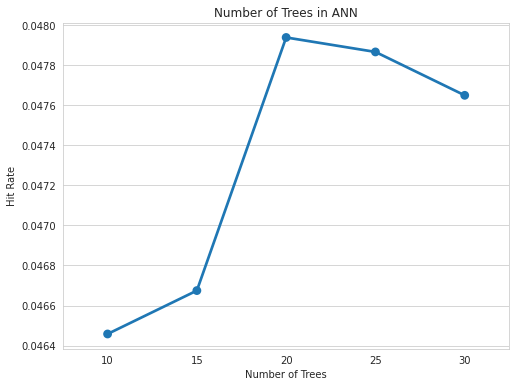

In [ ]:
trees = [10, 15, 20, 25, 30]
hit_rate_list = [0.04645785918138796, 0.04667461435641776, 0.04793901954409162, 0.04786676781908168, 0.04765001264405188]
cv_result_df2 = pd.DataFrame({'hit_rate': hit_rate_list, 'n_trees': trees})

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df2.n_trees, y=cv_result_df2.hit_rate, ax=ax)
ax.set(xlabel='Number of Trees', ylabel='Hit Rate', title='Number of Trees in ANN')

In [ ]:
# display the recommendation list
loaded_model = pickle.load(open('drive/MyDrive/Rec-Sys-models/nmf_model/nmf_model.sav', 'rb'))
item_vector = loaded_model.components_.T
def get_recommendation(data, dimension, matrix_cp, matrix, metric, num_tree, threshold, top_n):
    userIds = data.userId.unique()
    v = item_vector
    ann(matrix, v, metric, num_tree)     # save the ann in 'rating.ann' file
    f = len(v[1])
    u = AnnoyIndex(f, metric)
    filename = 'rating' + str(num_tree) + '.ann'
    u.load('drive/MyDrive/Rec-Sys-models/nmf_model/' + filename)
    # construct the recommendation list for each user
    recommendation_dict = {}
    for userid in userIds:
        high_rate_movie, rate = get_rated_movies(data, userid, threshold)
        movielist = []
        distancelist = []
        if len(high_rate_movie) > 1:
            # find neighborhood of each movies in the high rated movie set
            for movieid in high_rate_movie:
                movie, dist = u.get_nns_by_item(movieid, top_n, include_distances=True)
                movielist.extend(movie[1:])
                # get the weighted distance based on rating scores
                weighted_dist = (np.array(dist[1:])/rate[np.where(high_rate_movie == movieid)]).tolist()
                distancelist.extend(weighted_dist)  
            #if more than 20 movies are chosen to recommend to user, choose 20 nearest item for this user
            if len(movielist) > 20:
                sorted_recommend = np.array(movielist)[np.array(distancelist).argsort()]
                movielist = sorted_recommend[:20]
        recommendation_dict[userid] = movielist
    return recommendation_dict
recommendationn_list = get_recommendation(sample_df, 14, rating_matrix_cp, rating_matrix, 'angular', 20, 2, 10)

Нека видим препоръките на филми за някой юзър.

In [ ]:
# user_id = int(np.random.choice(sample_df.userId.unique(), 1))
user_id = 177984
print(f'recommendation for client: {user_id}')
movies = recommendationn_list[user_id]
movie_dt.loc[movie_dt['movieId'].isin(movies)]

recommendation for client: 177984


,movieId,title,genres
315,318,"Shawshank Redemption, The (1994)",Crime|Drama
523,527,Schindler's List (1993),Drama|War
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1058,1080,Monty Python's Life of Brian (1979),Comedy
1230,1258,"Shining, The (1980)",Horror
2598,2683,Austin Powers: The Spy Who Shagged Me (1999),Action|Adventure|Comedy
3122,3208,Loaded Weapon 1 (National Lampoon's Loaded Wea...,Action|Comedy
3422,3511,Ready to Rumble (2000),Comedy
3473,3563,"Crow: Salvation, The (2000)",Action|Horror
4114,4207,Navy Seals (1990),Action|Adventure|War


Нека пресметнем раличните RMSE грешки по-различните юзър групи по активност.

In [ ]:

user_counts = sample_df.groupby('userId').size()
active_levels = ['<10', '10-20', '20-50', '50-80', '80-150', '>150']

user_counts_levels = dict.fromkeys(active_levels, None)
user_counts_levels['<10'] = user_counts[user_counts < 10]
user_counts_levels['10-20'] = user_counts[(user_counts >= 10) & (user_counts < 20)]
user_counts_levels['20-50'] = user_counts[(user_counts >= 20) & (user_counts < 50)]
user_counts_levels['50-80'] = user_counts[(user_counts >= 50) & (user_counts < 80)]
user_counts_levels['80-150'] = user_counts[(user_counts >= 80) & (user_counts < 150)]
user_counts_levels['>150'] = user_counts[user_counts >= 150]

user_level_rmse = []
for key in active_levels:
    indices = user_counts_levels[key].index.tolist()
    pred_df = sample_df[sample_df['userId'].isin(indices)]
    rmse = get_nmf_rmse(pred_df, 14)
    user_level_rmse.append(rmse)

RMSE: 1.2461
RMSE: 1.1457
RMSE: 1.0082
RMSE: 0.9679
RMSE: 0.9320
RMSE: 0.8623


[Text(0, 0.5, 'RMSE'),
 Text(0.5, 0, 'User Count Level'),
 Text(0.5, 1.0, 'Number of User Rating and RMSE in NMF')]

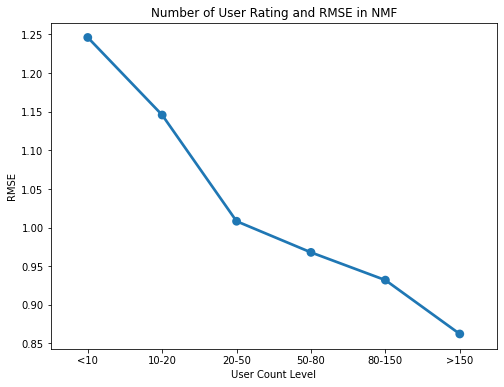

In [ ]:
# user_level_rmse = [1.2398, 1.1411, 1.0097, 0.9617, 0.9261, 0.8583]
cv_result_df3 = pd.DataFrame({'rmse': user_level_rmse, 'user_count_level': active_levels})

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df3.user_count_level, y=cv_result_df3.rmse, ax=ax)
ax.set(xlabel='User Count Level', ylabel='RMSE', title='Number of User Rating and RMSE in NMF')

In [ ]:
user_df = sample_df.loc[sample_df['userId'].isin(user_ids)]
movies = set(user_df['movieId'])
len(movies)

27374

nDCG оценка

In [ ]:

np.random.seed(123)
userid_random = np.random.choice(sample_df['userId'], 100, replace=False)
rel_list = []
for user in userid_random:
    recommended = recommendationn_list[user]
    rated_movie = sample_df.loc[sample_df['userId'] == user]
    rated_movie_ids = rated_movie['movieId'].tolist()
    rel = []
    for index, item in enumerate(recommended):
        if item in rated_movie_ids:
            movie_rating = rated_movie.loc[rated_movie['movieId'] == item, 'rating'].item()
            if movie_rating >= 4:
                rel.append(2)
            elif movie_rating >= 2 and movie_rating < 4:
                rel.append(1)
            else:
                rel.append(0)
    rel_list.append(rel)
ndcg_sum = 0
for r in rel_list:
    dcg = 0
    idcg = 0
    for i, value in enumerate(r):
        dcg += value/np.log(i+2)
    r.sort(reverse=True)
    for i, value in enumerate(r): 
        idcg += value/np.log(i+2)
    ndcg = 0
    if idcg != 0:
      ndcg = dcg/idcg
    ndcg_sum += ndcg

print(ndcg_sum/len(rel_list))

0.5410677935442871


#Hybrid system

Поради рънтайм ограничения няма да използваме целият дейтасет, а на случаен принцип ще изберем 10% от потребителите и ще имплментираме switching модел, в който потребителите биват насочeни към различни препоръки зависимост от профила им.

В нашият хибриден модел ще използваме три различни алгоритъма в зависимост от потрбителския профил:
- за нови потребители (cold-start), препоръчваме top-k филми с най-висок рейтинг и най-голям брой рейтинги.
- за потребители, които са оценили по-малко от 50 филма, препоръчваме само с NCF
- за потрбители, оценили между 50 и 150 филма, препоръчваме с NCF и ANN, като NCF има по-голяма тежест
- за потребители с повече от 150 рейтинга на филми , препоръчваме отново с двата модела като имат равна тежест

Тъй като моделът ни главно се фокусира върху съществуващи потребители, препоръчваме популярни и най-високо рейтнати филми за нови потребители с цел простота. Наблюдавахме поведението на NCF и АNN модела върху потребители с различни нива на участие и открихме, че NCF моделът се представя по-добре от всички други модели, когато потребителският профил е ограничен. Поради тази причина даваме повече тежест при препоръки за потребители, които са оценили по-малко от 150 филма.

In [ ]:
rating_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/ratings.csv')
movie_dt = pd.read_csv('drive/MyDrive/RecSys-Datasets/ml-latest-27mil-ratings/movies.csv')

In [ ]:
# This is the Ensemble method that combines NCF DL model with MF-ANN model.
# The ensemble recommender loads and takes recommendations from two pre-trained model,
#    and make recommendation based on user's profile by feeding the user into different model,
#    or add weights to each recommendation to make the final recommendation

class EnsembleRecommender():
    def __init__(self,rating_df,movie_df, rating_matrix, item_vector):
        # class initializer input: - rating_df  a user rating dataframe, containing 'userIds', 'movieIds', 'rating'
        #                          - movie_df   a movie info dataframe, containing 'movieIds', 'title', 'genre'
        #                          - userId     a single userId that the model is recommending for
        #                          - rating_martrix    a user-movie matrix
        #                          - item_vector       the vector representation of each movie learned by MF
        #
        # initialize the variables for recommendation functions
        self.rating_df = rating_df
        self.movie_df = movie_df
        self.user_ids = rating_df['userId'].unique()
        self.movie_ids = rating_df['movieId'].unique()
        self.user2user_encoded = {x: i for i, x in enumerate(self.user_ids)}
        self.movie2movie_encoded = {x: i for i, x in enumerate(self.movie_ids)}
        self.movie_encoded2movie = {i: x for i, x in enumerate(self.movie_ids)}
        self.rating_matrix = rating_matrix
        self.item_vector = item_vector
        

    def NCF_recommendation(self,userId,dcg_eval, top_k=20):
        # make recommendation based on NCF model
        # input: - top_k  the number of recommendations made
        #        - userId     a single userId that the model is recommending for
        # output: a dataframe containing index as 'movieId','prediction','title','genre'
        
        # load the pre-trained NCF model
        model =  tf.keras.models.load_model('drive/MyDrive/Rec-Sys-models/dl_model.h5')
        
        # get the encoded userId
        client_encoded = self.user2user_encoded[userId]
        
        # get user rated movies
        movie_watched = self.rating_df[self.rating_df['userId'] == userId]['movieId'].values
        
        # get the movies user have not rated in which the NCF  will recommend 
        movie_poll_encoded = []
        if dcg_eval:
          for item in self.movie_ids:
              movie_poll_encoded.append(self.movie2movie_encoded[item])
        else:
          for item in self.movie_ids:
              if not np.isin(item, movie_watched):
                  movie_poll_encoded.append(self.movie2movie_encoded[item])

        
        # encode the unrated movies into a dataframe
        d = {'user_encoded': [client_encoded] * len(movie_poll_encoded), 'movie_encoded' : movie_poll_encoded}
        client_df = pd.DataFrame(d)
        
        # use the model to predict user's rating on these movies
        ratings = model.predict([client_df['user_encoded'], client_df['movie_encoded']])
        
        # sort the movies according to the predicted ratings and take top k
        top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
        top_ratings = ratings[top_ratings_idx].flatten()
        recommend_movieId = [self.movie_encoded2movie.get(movie_poll_encoded[x]) for x in top_ratings_idx]
        
        # format the output for better user experience
        top_movie_rec = pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings}).set_index('movieId')
        top_movie_rec = top_movie_rec.join(self.movie_df.set_index('movieId'))
        
        return top_movie_rec[['title','genres']]
    
    
    # make recommendation based on MF-ANN model
    def get_rated_movies(self,userId,threshold=2):    
        # input:  userid, a rating threshold, movies that are rated below threshold
        # will not be counted 
        # output: a list of high-scored movies that are rated by givern user, a list of corresponding ratings
        #
        all_rates = self.rating_df[self.rating_df['userId'] == userId]
        high_rates = all_rates[all_rates['rating'] >= threshold]['rating'].values
        high_rate_movie = all_rates[all_rates['rating'] >= threshold]['movieId'].values
        return high_rate_movie, high_rates

    
    def ann(self, metric, num_trees):
        # Implement Approximate Nearest Neighborhood to find similar items, save it in 'rating.ann' 
        # input: target movie, rating matrix, item_vectors, metric (can be "angular", "euclidean", "manhattan", "hamming")
        #        number of trees(More trees gives higher precision when querying)
        # output: save it in 'rating.ann' 
        #
        # construct a dictionary where movied id contains its vector representation 
        rating_dictionary = {self.movie_ids[i]: self.item_vectors[i] for i in range(len(self.movie_ids))} 
        # ann method
        f = len(self.item_vectors[1])
        t = AnnoyIndex(f, metric)  # Length of item vector that will be indexed
        for key in rating_dictionary:
            t.add_item(key, rating_dictionary.get(key))
        t.build(num_trees) # 10 trees
        t.save('rating.ann')

    
    def ANN_recommendation(self,userId, dimension = 14, metric = 'angular',
                           num_tree=20, threshold=2, top_n=10):
        # use the trained ANN model to recommend the nearest movies to user's rated movies
        # input: - dimension,metric,
        #          num_tree,threshold,   learned parameter from ANN cv
        #          top_n   
        # output: a dataframe containing index as 'movieId','title','genre'
        #
        v = self.item_vector
        #ann(metric, num_tree) 
        f = len(v[1])
        u = AnnoyIndex(f, metric)
        filename = 'rating' + str(num_tree) + '.ann'
        u.load('drive/MyDrive/Rec-Sys-models/nmf_model/' + filename)
        # u.load('rating.ann')
        
        # construct the recommendation for the user
        high_rate_movie, rate = self.get_rated_movies(userId,threshold=threshold)
        movielist = []
        distancelist = []
        
        if len(high_rate_movie) > 1:
            # find neighborhood of each movies in the high rated movie set
            for movieid in high_rate_movie:
                movie, dist = u.get_nns_by_item(movieid, top_n, include_distances=True)
                movielist.extend(movie[1:])
                
                # get the weighted distance based on rating scores
                weighted_dist = (np.array(dist[1:])/rate[np.where(high_rate_movie == movieid)]).tolist()
                distancelist.extend(weighted_dist)  
                
            #if more than 20 movies are chosen to recommend to user, choose 20 nearest item for this user
            if len(movielist) > 20:
                sorted_recommend = np.array(movielist)[np.array(distancelist).argsort()]
                movielist = sorted_recommend[:20]
        
        # construct a dataframe for final output
        top_movie_rec = self.movie_df.loc[self.movie_df['movieId'].isin(movielist)].set_index('movieId')
        
        return top_movie_rec
    
    
    def Popular_recommendation(self, top_k = 20):
        # recommend only the most popular movies to the user
        # define popularity as: at least 1000 reviews, 
        #                       at least 4.0 average rating
        # output: a dataframe containing the top_k most popular movies
        #
        # calculate the average rating and number of reviews for each movie
        grouped_rating = self.rating_df.groupby('movieId')['rating'].mean()
        grouped_count = self.rating_df.groupby('movieId')['movieId'].count()
        
        # form them into datasets
        df_grouped = pd.DataFrame(grouped_count)
        df_grouped.columns = ['count']

        df_group_avg = pd.DataFrame(grouped_rating)
        df_group_avg.columns = ['avg_rating']
        
        # join two datasets and order by count and avg_rating
        df_grouped = df_grouped.join(df_group_avg, on ='movieId')
        df_grouped.sort_values(by=['count','avg_rating'], ascending=False)
        
        # get the top_k movies
        top_k_rec = df_grouped.loc[df_grouped['count'] > 1000].loc[df_grouped['avg_rating']>4.0][:top_k]
        
        # construct a dataframe for final output
        top_movie_rec = self.movie_df.loc[self.movie_df['movieId'].isin(top_k_rec.index.values)].set_index('movieId')
        
        return top_movie_rec
    
    def User_Classification(self,userId):
        # classify users based on the number of movies they have rated to decide how to recommend
        # input: - userId     a single userId that the model is recommending for
        # output: the classification of user's rating record with value '0','1-50','51-150','151'
        #
        if userId not in self.user_ids:
            return '0'
        else:
            num_of_rated_movies = len(self.rating_df.loc[self.rating_df.userId == userId]['movieId'].unique())
            if 1 < num_of_rated_movies < 50:
                return '1-50'
            elif 51 < num_of_rated_movies < 150:
                return '51-150'
            else:
                return '151'
    
    
    def Recommend(self, userId, dcg_eval):
        # if the user have not rated any movies, recommend the most popular movies
        # if the user have rated 1 - 50 movies, recommend with NCF model only
        # if the user have rated 51 - 150 movies, recommend with both NCF and ANN model, with more weights on NCF model
        # if the user have rated more than 151 movies, recommend with both NCF and ANN model, with equal weights
        # input: - userId     a single userId that the model is recommending for
        # output: the comprehensive recommendation for the specific user
        # 
        classification = self.User_Classification(userId)
        
        if classification == '0':
            return self.Popular_recommendation()
        elif classification == '1-50':
            return self.NCF_recommendation(userId, dcg_eval)
        elif classification == '51-150':
            return self.NCF_recommendation(userId, dcg_eval)[:15].append(self.ANN_recommendation(userId)[:5])
        else:
            return self.NCF_recommendation(userId, dcg_eval)[:10].append(self.ANN_recommendation(userId)[:10])

In [ ]:
user_ids = rating_dt["userId"].unique().tolist() 
num_all_user = len(user_ids)

# randomly select 10% users from rating dataset 
np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.1), replace=False)
sample_df = rating_dt.loc[rating_dt['userId'].isin(rand_userid)]

In [ ]:
# pivot movie, user, rating dataframe into compressed matrix
def movie_use_matrix_pivot(df_):
    mu_matrix = df_.pivot(index = 'userId', 
                          columns = 'movieId', 
                          values = 'rating').fillna(0)
    # compress original matrix
    mu_matrix_cp = csr_matrix(mu_matrix.values)
    return mu_matrix, mu_matrix_cp
# get rating matrix
rating_matrix, rating_matrix_cp = movie_use_matrix_pivot(sample_df)

In [ ]:
filename = 'drive/MyDrive/Rec-Sys-models/nmf_model/nmf_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
item_vector = loaded_model.components_.T

In [ ]:
Ensemble = EnsembleRecommender(sample_df, movie_dt,rating_matrix,item_vector )

In [ ]:
# user 14 has more than 150 ratings
Ensemble.Recommend(14, False)

,title,genres
movieId,,
159817,Planet Earth (2006),Documentary
3030,Yojimbo (1961),Action|Adventure
40412,Dead Man's Shoes (2004),Crime|Thriller
670,"World of Apu, The (Apur Sansar) (1959)",Drama
7925,"Hidden Fortress, The (Kakushi-toride no san-ak...",Action|Adventure
65188,Dear Zachary: A Letter to a Son About His Fath...,Documentary
912,Casablanca (1942),Drama|Romance
3022,"General, The (1926)",Comedy|War
170705,Band of Brothers (2001),Action|Drama|War


In [ ]:
rel_list = []
userid_random = np.random.choice(rand_userid, 100, replace=False)
for user in userid_random:
    user_predictions = Ensemble.Recommend(user, True)
    recommended = []
    rate = []
    rel = []    
    for movieId, row in user_predictions.iterrows():
        rating_in_df = sample_df.loc[(sample_df['userId'] == user) & (sample_df['movieId'] == movieId)]
        if not rating_in_df.empty:
          if rating_in_df['rating'].item() >= float(4):
              rel.append(2)
          elif rating_in_df['rating'].item() >= float(2) and rating_in_df['rating'].item() < float(4):
              rel.append(1)
          else:
              rel.append(0)
    rel_list.append(rel)

dcg_sum = 0
ndcg_sum = 0

for r in rel_list:
    dcg = 0
    idcg = 0
    for i, value in enumerate(r):
        dcg += value/np.log(i+2)
    r.sort(reverse=True)
    for i, value in enumerate(r): 
        idcg += value/np.log(i+2)
    ndcg = 0
    if idcg != 0:
      ndcg = dcg/idcg
    ndcg_sum += ndcg

print(ndcg_sum/len(rel_list))

0.7977724250769785


| nDCG20      | value |
| ----------- | ----------- |
| Hybrid      | 0.79777       |
| NCF   | 0.9636       |
| NMF-ANN   | 0.5410        |
| CF   | 0.9275       |